In [2]:
import math
import random
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from IPython import display
from perlin_noise import PerlinNoise

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
device = torch.device("mps")

In [4]:
# Transition class: named tuple representing a single transition in the environment.
# maps (s,a) pairs to (s', r) result. State here is (partly) observed map.
# ReplayMemory: buffer of bounded size that holds recently observed transitions
# should implement a .sample() method for selecting a random batch of transitions for training.

# state consists of currently explored reward map, coordiantes of robot, current move, and total moves.
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        # saves transition in replay memory
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
# environment here is currently determininstic (?? is it?)
# TODO: modify to contain expectations over transitions in environment. (non-deterministic)
# maximize discounted cumulative reward (discount param gamma)
# want neural net to be our Q function on (s,a). Input s, output Q(s,a) for all actions possible
# policy pi defined by this neural net is pi(s) = argmax(a) Q(s,a)
# update through temporal difference learning:
# Q_pi(s,a) = r + gamma*(Q_pi(s', pi(s'))) = B
# sum of expected reward from (s,a) --> r and the Q value of subsequent state s' and pi(s').
# There should be an expectation here...expectation over all end states s', and transition probabilities.
# temporal difference error: delta = Q(s,a) - (r + gamma*(max Q(s', a)))
# Huber loss: MSE when error small, MAE when error large --> robust to outliers when we have noisy estimates of Q

# model is a CNN that takes in the difference between the current and previous screen patches
# two outputs: one for Q(s, left) and one for Q(s, right)

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(8)

        def conv2d_size_out(size, kernel_size=3, stride=1):
            # want to make sure the layer sizes change even with different input image sizes
            return (size - (kernel_size-1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

        linear_input_size = (convw*convh*32) + 7 # also inputting robot coordinates, current move, total moves, 3 more related to map size and obs size
        self.fc1 = nn.Linear(linear_input_size, linear_input_size)
        #self.fc2 = nn.Linear(linear_input_size*2, linear_input_size*2)
        #self.fc3 = nn.Linear(linear_input_size*2, linear_input_size)
        self.head = nn.Linear(linear_input_size, outputs)
    
    def forward(self, state):
        rmap, radditional = state
        if rmap.dim() == 2:
            rmap = torch.unsqueeze(rmap, 0)
            rmap = torch.unsqueeze(rmap, 0)
        if rmap.dim() == 3:
            rmap = torch.unsqueese(rmap, 1)
        if radditional.dim() == 1:
            radditional = torch.unsqueeze(radditional, 0)
        rmap = rmap.to(device)
        radditional = radditional.to(device)
        rmap = F.relu(self.bn1(self.conv1(rmap)))
        rmap = F.relu(self.bn2(self.conv2(rmap)))
        rmap = F.relu(self.bn3(self.conv3(rmap)))
        x = torch.cat((rmap.view(rmap.size(0), -1), radditional.view(radditional.size(0), -1)), dim=1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        return self.head(x)

In [ ]:
BATCH_SIZE = 50
GAMMA = 0.999
EPS_START = 0.9 # high exploration initially
EPS_END = 0.05 # low exploration at end
EPS_DECAY = 200 # controls epsilon decay rate
TARGET_UPDATE = 10
N_ACTIONS = 8
N_MAPS = 10
MAP_SIZE = 200
OBS_SIZE = 20
N_MOVES = 40

In [8]:
policy_net = DQN(MAP_SIZE, MAP_SIZE, N_ACTIONS).to(device)
target_net = DQN(MAP_SIZE, MAP_SIZE, N_ACTIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000)

# select_action function selects action according to epsilon greedy policy
# parameter epsilon is the probability of exploring instead of exploiting.
# plot_durations function is a helper for plotting durations of episodes
# along with an average over last 100 episodes.
steps_done = 0

def select_action(state):
    global steps_done
    # sample from 0-1 uniform
    sample = random.random()
    # exponential decay of epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # not within epsilon, so we exploit
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # within epsilon, explore. here we are returning random actions.
        return torch.tensor([[random.randrange(N_ACTIONS)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(wipe=True):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.3)  # pause a bit so that plots are updated
    if wipe:
        display.clear_output(wait=True)
        display.display(plt.gcf())

: 

: 

In [12]:
# optimize_model function performs sincle step of optimization.
# samples batch, concatenates tensors, computes Q(s_t, a_t) and V(s_t+1) = max Q(s_t+1, a)
# combines these into our loss. V(s) = 0 if terminal state.
# target network computes V(s_t+1) for stability. Target network parameters frozen and are updated
# with policy network's weights at regular intervals.

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch=Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # final state is one where the current moves == total allowed moves
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = (torch.cat([s[0].view(1, 1, 200, 200) for s in batch.next_state if s is not None]).to(device), torch.cat([s[1].view(1,4) for s in batch.next_state if s is not None]).to(device))

    state_batch = (torch.cat([s[0].view(1, 1, 200, 200) for s in batch.state]).to(device), torch.cat([s[1].view(1,7) for s in batch.state]).to(device))
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Compute Q(s_t, a) -- model computes Q(s_t), then we select
    # the columns of actions taken. These are actions which would have
    # been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_t+1) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # compute expected q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute Huber Loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        # in place version of clamp
        # lol why are we doing this...
        param.grad.data.clamp_(-1,1)
    optimizer.step()

In [13]:
# map generation function
def generate_map(size=1000):
    oct1 = random.randint(1,4)
    oct2 = random.randint(3,6)
    oct3 = random.randint(5,8)
    oct4 = random.randint(7,10)
    noise1 = PerlinNoise(octaves=oct1)
    noise2 = PerlinNoise(octaves=oct2)
    noise3 = PerlinNoise(octaves=oct3)
    noise4 = PerlinNoise(octaves=oct4)
    xpix, ypix = size, size

    pic = []
    for i in range(xpix):
        row = []
        for j in range(ypix):
            noise_val = noise1([i/xpix, j/ypix])
            noise_val += 0.5 * noise2([i/xpix, j/ypix])
            noise_val += 0.25 * noise3([i/xpix, j/ypix])
            noise_val += 0.125 * noise4([i/xpix, j/ypix])

            row.append(noise_val)
        pic.append(row)

    pic = np.array(pic)
    # min-max normalize so that all values are between 0 and 1
    pic = (pic - np.min(pic))/(np.max(pic) - np.min(pic))
    
    return pic

def get_observation(truemap, obs_coords, obs_size=25):
    row, col = obs_coords
    observation = np.array(truemap)[row*obs_size:(row+1)*obs_size, col*obs_size:(col+1)*obs_size]
    noise = np.random.uniform(high=np.mean(observation)/20, size=observation.shape)
    noisy_observation = observation + noise
    noisy_observation = (noisy_observation - np.min(noisy_observation))/(np.max(noisy_observation)-np.min(noisy_observation))
    location = (row*obs_size,(row+1)*obs_size,col*obs_size,(col+1)*obs_size)
    # simple reward: sum of pixels in observation
    reward = np.sum(observation)
    
    return observation, noisy_observation, location, reward

def action_to_location(currloc, action, obs_size, map_size):
    # Actions are:
    # 7  0  1
    # 6  x  2
    # 5  4  3
    obs_locs = map_size // obs_size
    oldr, oldc = currloc
    newr, newc = currloc
    if action == 0:
        newr = oldr - 1 if oldr > 0 else oldr
        newc = oldc
    if action == 1:
        newr = oldr - 1 if oldr > 0 else oldr
        newc = oldc + 1 if newc < obs_locs-1 else oldc
    if action == 2:
        newr = oldr
        newc = oldc + 1 if newc < obs_locs-1 else oldc
    if action == 3:
        newr = oldr + 1 if newr < obs_locs-1 else oldr
        newc = oldc + 1 if newc < obs_locs-1 else oldc
    if action == 4:
        newr = oldr + 1 if newr < obs_locs-1 else oldr
        newc = oldc
    if action == 5:
        newr = oldr + 1 if newr < obs_locs-1 else oldr
        newc = oldc - 1 if oldc > 0 else oldc
    if action == 6:
        newr = oldr
        newc = oldc - 1 if oldc > 0 else oldc
    if action == 7:
        newr = oldr - 1 if oldr > 0 else oldr
        newc = oldc - 1 if oldc > 0 else oldc
    return (newr, newc)

In [14]:
# generate different maps.
all_maps = [generate_map(size=MAP_SIZE) for i in range(N_MAPS)]

In [15]:
# training loop
for i_map in range(N_MAPS//40):
    # initialize environment and state
    if i_map % 5 == 0:
        print("Episode", i_map)
    # get the initial map for this iteration from the all_maps list
    true_map = all_maps[i_map]
    # select a random starting position for the robot
    curr_row = random.randint(0,(MAP_SIZE//OBS_SIZE)-1)
    curr_col = random.randint(0,(MAP_SIZE//OBS_SIZE)-1)
    curr_moves = 0
    curr_observed_map = np.zeros((MAP_SIZE, MAP_SIZE))
    # get observation at initial location
    true_obs, noisy_obs, curr_obsloc, reward = get_observation(true_map, (curr_row, curr_col), obs_size=OBS_SIZE)
    # use the true observation for now. Will use noisy later.
    curr_observed_map[curr_obsloc[0]:curr_obsloc[1], curr_obsloc[2]:curr_obsloc[3]] = np.copy(true_obs)
    next_observed_map = np.copy(curr_observed_map)
    # additional robot information in state: current location, curr moves, total moves, observation size, map size, obs length
    curr_r_additional = np.array([curr_row, curr_col, curr_moves, N_MOVES, OBS_SIZE, MAP_SIZE, OBS_SIZE//MAP_SIZE])
    next_r_additional = np.copy(curr_r_additional)
    #state is a tuple of currently observed map and additional robot info
    curr_state = (curr_observed_map, curr_r_additional)
    done = False
    for m in range(1,N_MOVES+1):
        torch_curr_observed_map = torch.FloatTensor(np.copy(curr_state[0]))
        torch_curr_r_additional = torch.FloatTensor(np.copy(curr_state[1]))
        torch_curr_state = (torch_curr_observed_map, torch_curr_r_additional)
        # select and perform action. Actions are:
        # 7  0  1
        # 6  x  2
        # 5  4  3
        action = select_action(torch_curr_state)
        # retrieve new location based on action
        next_row, next_col = action_to_location((curr_r_additional[0], curr_r_additional[1]), action, OBS_SIZE, MAP_SIZE)
        # we've made an additional move
        next_moves = curr_r_additional[2] + 1
        # check if we have made maximum moves. set done accordingly
        if next_moves == N_MOVES:
            done = True
        # observe at new location
        next_true_obs, next_noisy_obs, next_obsloc, next_reward = get_observation(true_map, (next_row, next_col), obs_size=OBS_SIZE)
        # so they are receiving some type of reward from environment here.
        # need to decide how this function will operate
        reward = torch.FloatTensor([reward])

        if(next_obsloc == curr_obsloc):
            reward = torch.FloatTensor([0.0])

        # construct new state
        if not done:
            next_observed_map[next_obsloc[0]:next_obsloc[1], next_obsloc[2]:next_obsloc[3]] = np.copy(next_true_obs)
            next_r_additional = np.array([next_row, next_col, next_moves, N_MOVES])
            torch_next_observed_map = torch.FloatTensor(next_observed_map)
            torch_next_r_additional = torch.FloatTensor(next_r_additional)
            torch_next_state = (torch_next_observed_map, torch_next_r_additional)
            next_state = (next_observed_map, next_r_additional)
        else:
            # end state reached, moves exhausted
            next_state = None
        
        # store transition in memory
        memory.push(torch_curr_state, action, torch_next_state, reward)

        # move curr state to next state
        curr_state = next_state
        curr_observed_map = next_observed_map
        curr_r_additional = next_r_additional
        curr_obsloc = next_obsloc

        # perform one step of optimization (only on policy network rn)
        # optimization only occurs when len of replay buffer >= batch size.
        # (was worried about that.)
        optimize_model()
        if done:
            break

        # update target network by copying from policy net
        if m % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print("Complete")
plt.ioff()
plt.show()

Episode 0


: 

: 

In [54]:
test_map = generate_map(size=MAP_SIZE)

In [59]:
# testing on test_map!
# select a random starting position for the robot
test_maps = []
test_radditional = []
test_actions = []
curr_test_row = random.randint(0,(MAP_SIZE//OBS_SIZE)-1)
curr_test_col = random.randint(0,(MAP_SIZE//OBS_SIZE)-1)
curr_test_moves = 0
curr_test_observed_map = np.zeros((MAP_SIZE, MAP_SIZE))
# get observation at initial location
true_test_obs, noisy_test_obs, curr_test_obsloc, test_reward = get_observation(test_map, (curr_test_row, curr_test_col), obs_size=OBS_SIZE)
# use the true observation for now. Will use noisy later.
curr_test_observed_map[curr_test_obsloc[0]:curr_test_obsloc[1], curr_test_obsloc[2]:curr_test_obsloc[3]] = np.copy(true_test_obs)
next_test_observed_map = np.copy(curr_test_observed_map)
# additional robot information in state: current location, curr moves, total moves
curr_test_r_additional = np.array([curr_test_row, curr_test_col, curr_test_moves, N_MOVES])
next_test_r_additional = np.copy(curr_test_r_additional)
#state is a tuple of currently observed map and additional robot info
curr_test_state = (curr_test_observed_map, curr_test_r_additional)
done = False
for m in range(1,N_MOVES+1):
    test_maps.append(np.copy(curr_test_observed_map))
    test_radditional.append(np.copy(curr_test_r_additional))
    torch_curr_test_observed_map = torch.FloatTensor(np.copy(curr_test_state[0]))
    torch_curr_test_r_additional = torch.FloatTensor(np.copy(curr_test_state[1]))
    torch_curr_test_state = (torch_curr_test_observed_map, torch_curr_test_r_additional)
    # select and perform action. Actions are:
    # 7  0  1
    # 6  x  2
    # 5  4  3
    action = select_action(torch_curr_test_state)
    test_actions.append(action)
    # retrieve new location based on action
    next_test_row, next_test_col = action_to_location((curr_test_r_additional[0], curr_test_r_additional[1]), action, OBS_SIZE, MAP_SIZE)
    # we've made an additional move
    next_test_moves = curr_test_r_additional[2] + 1
    # check if we have made maximum moves. set done accordingly
    if next_test_moves == N_MOVES:
        done = True
    # observe at new location
    next_test_true_obs, next_test_noisy_obs, next_test_obsloc, next_test_reward = get_observation(test_map, (next_test_row, next_test_col), obs_size=OBS_SIZE)
    # so they are receiving some type of reward from environment here.
    # need to decide how this function will operate
    test_reward = torch.FloatTensor([test_reward])

    # construct new state
    if not done:
        print("next obsloc", next_test_obsloc)
        print("curr obsloc", curr_test_obsloc)
        next_test_observed_map[next_test_obsloc[0]:next_test_obsloc[1], next_test_obsloc[2]:next_test_obsloc[3]] = np.copy(next_test_true_obs)
        next_test_r_additional = np.array([next_test_row, next_test_col, next_test_moves, N_MOVES])
        torch_next_test_observed_map = torch.FloatTensor(next_test_observed_map)
        torch_next_test_r_additional = torch.FloatTensor(next_test_r_additional)
        torch_next_test_state = (torch_next_test_observed_map, torch_next_test_r_additional)
        next_test_state = (next_test_observed_map, next_test_r_additional)
    else:
        # end state reached, moves exhausted
        next_test_state = None

    # move curr state to next state
    curr_test_state = next_test_state
    curr_test_observed_map = next_test_observed_map
    curr_test_r_additional = next_test_r_additional
    curr_test_obsloc = next_test_obsloc

    if done:
        break

next obsloc (20, 40, 100, 120)
curr obsloc (0, 20, 80, 100)
next obsloc (40, 60, 120, 140)
curr obsloc (20, 40, 100, 120)
next obsloc (60, 80, 140, 160)
curr obsloc (40, 60, 120, 140)
next obsloc (80, 100, 160, 180)
curr obsloc (60, 80, 140, 160)
next obsloc (100, 120, 180, 200)
curr obsloc (80, 100, 160, 180)
next obsloc (120, 140, 180, 200)
curr obsloc (100, 120, 180, 200)
next obsloc (140, 160, 180, 200)
curr obsloc (120, 140, 180, 200)
next obsloc (160, 180, 180, 200)
curr obsloc (140, 160, 180, 200)
next obsloc (180, 200, 180, 200)
curr obsloc (160, 180, 180, 200)
next obsloc (180, 200, 180, 200)
curr obsloc (180, 200, 180, 200)
next obsloc (180, 200, 180, 200)
curr obsloc (180, 200, 180, 200)
next obsloc (180, 200, 180, 200)
curr obsloc (180, 200, 180, 200)
next obsloc (160, 180, 180, 200)
curr obsloc (180, 200, 180, 200)
next obsloc (180, 200, 180, 200)
curr obsloc (160, 180, 180, 200)
next obsloc (180, 200, 180, 200)
curr obsloc (180, 200, 180, 200)
next obsloc (180, 200, 180, 

In [60]:
for i in range(len(test_radditional)):
    print(test_radditional[i])

[ 0  4  0 40]
[ 1  5  1 40]
[ 2  6  2 40]
[ 3  7  3 40]
[ 4  8  4 40]
[ 5  9  5 40]
[ 6  9  6 40]
[ 7  9  7 40]
[ 8  9  8 40]
[ 9  9  9 40]
[ 9  9 10 40]
[ 9  9 11 40]
[ 9  9 12 40]
[ 8  9 13 40]
[ 9  9 14 40]
[ 9  9 15 40]
[ 9  9 16 40]
[ 9  9 17 40]
[ 9  9 18 40]
[ 9  9 19 40]
[ 9  9 20 40]
[ 9  9 21 40]
[ 9  9 22 40]
[ 9  9 23 40]
[ 9  9 24 40]
[ 9  9 25 40]
[ 9  9 26 40]
[ 9  9 27 40]
[ 9  9 28 40]
[ 9  9 29 40]
[ 9  9 30 40]
[ 9  9 31 40]
[ 9  9 32 40]
[ 9  9 33 40]
[ 9  9 34 40]
[ 9  9 35 40]
[ 9  9 36 40]
[ 9  9 37 40]
[ 9  9 38 40]
[ 9  9 39 40]


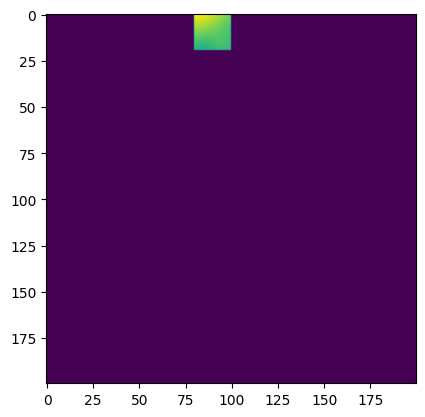

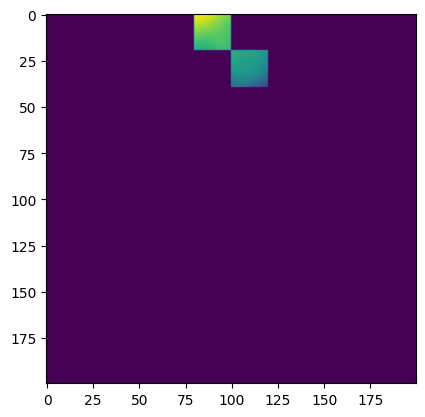

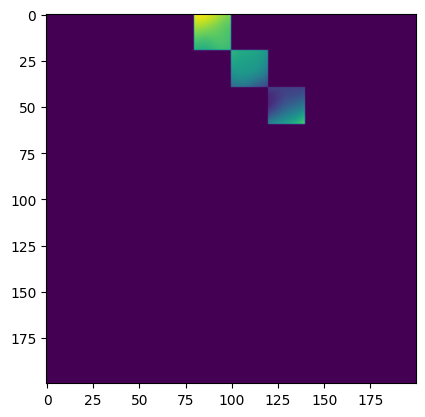

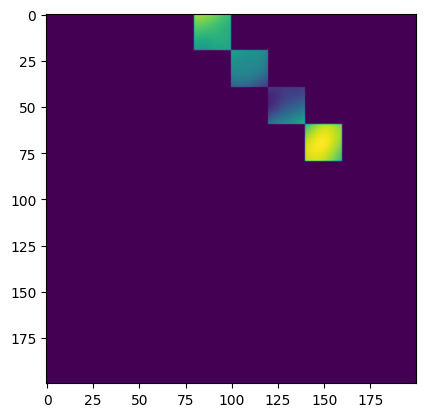

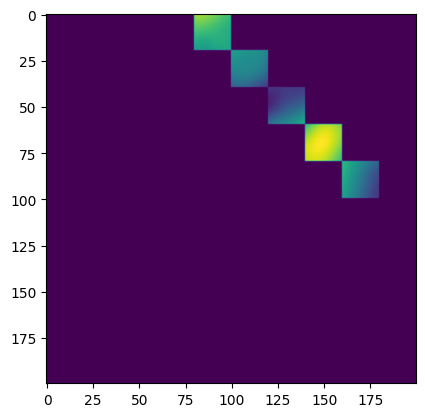

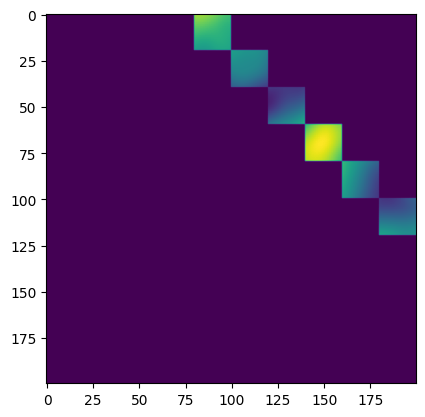

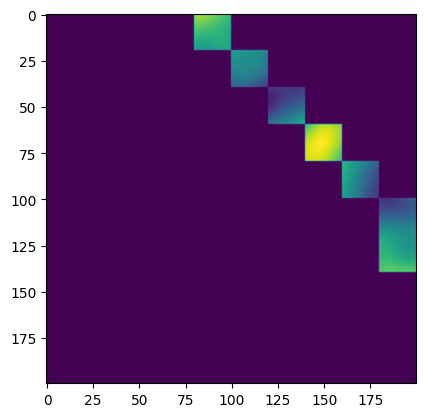

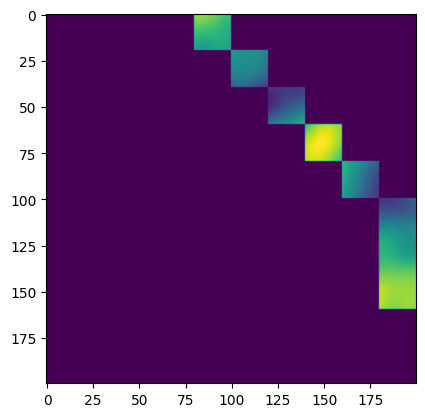

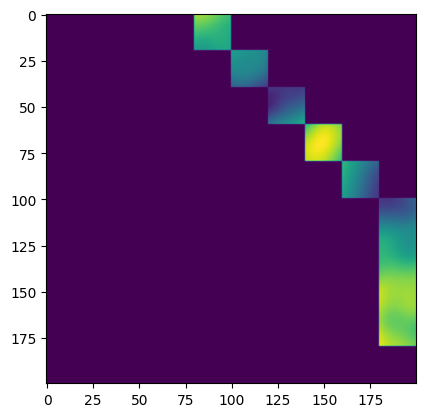

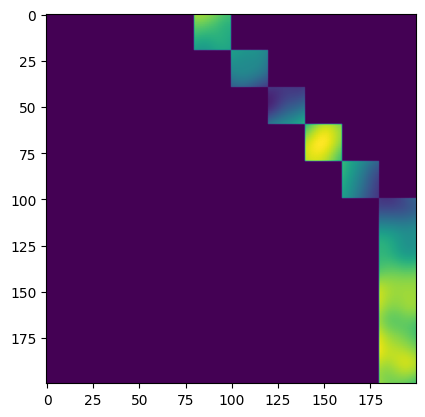

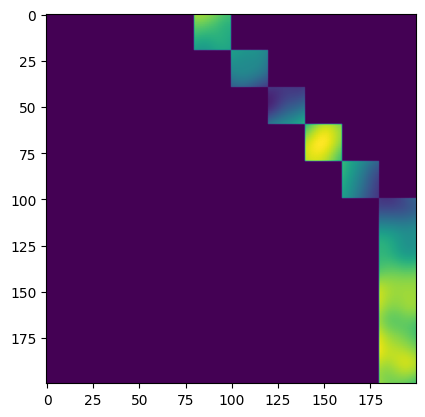

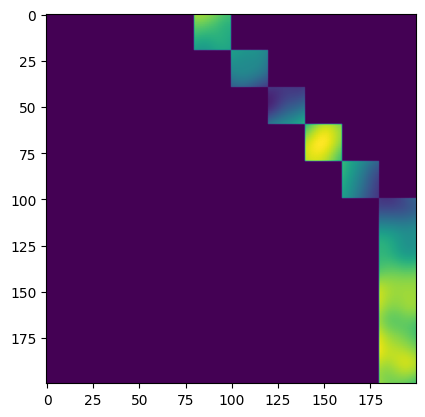

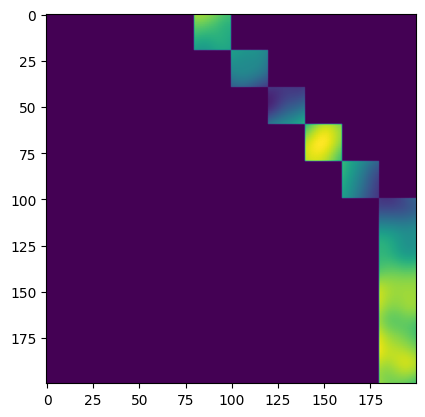

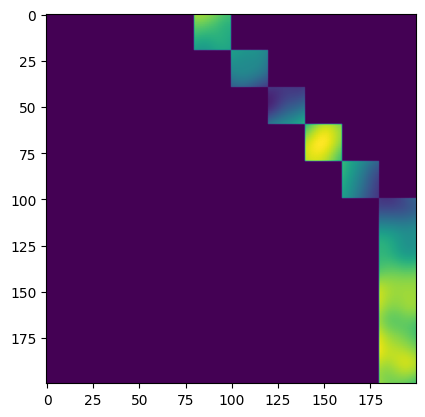

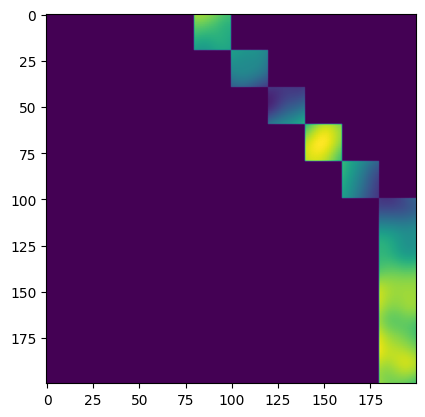

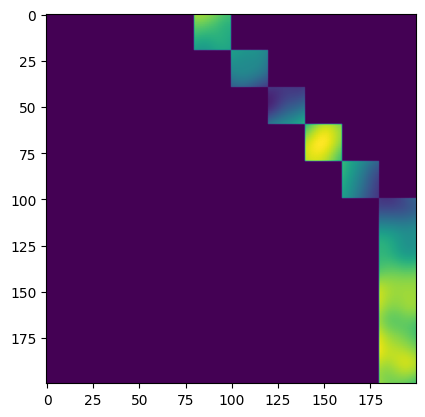

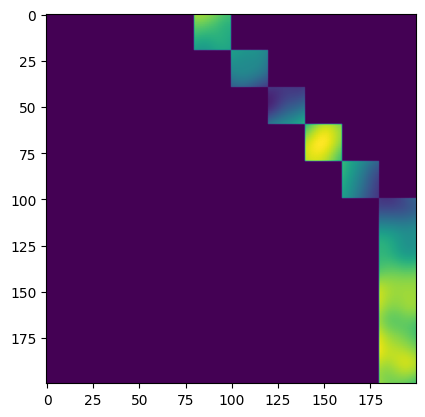

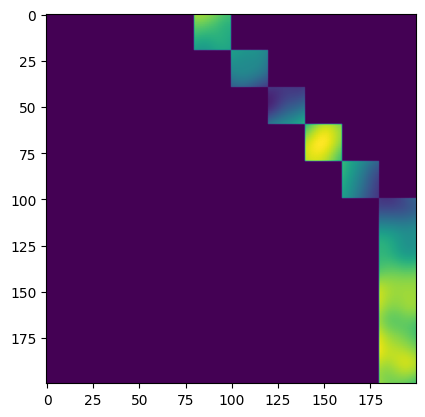

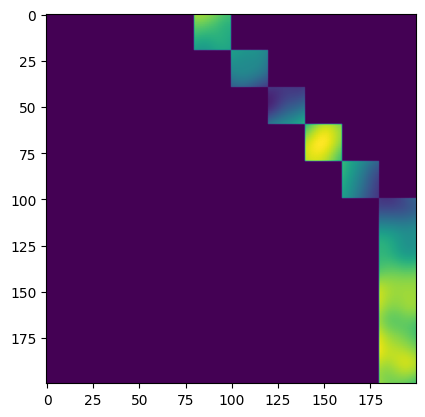

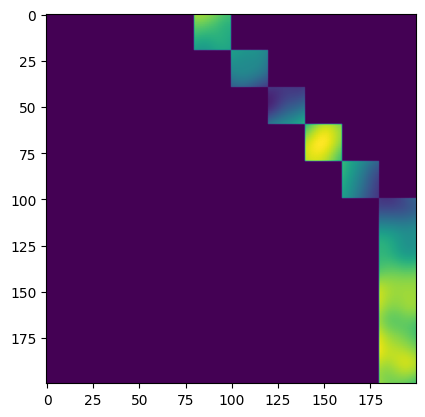

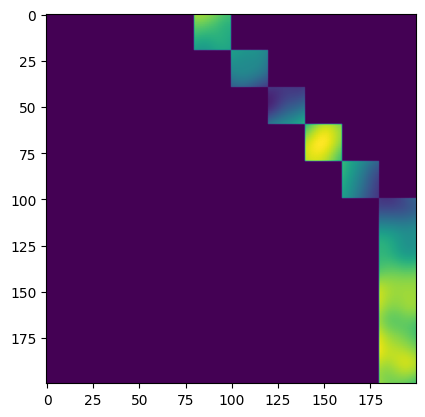

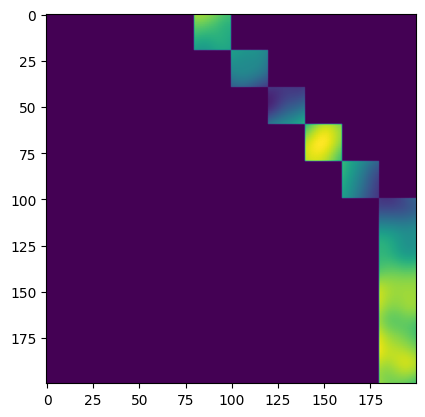

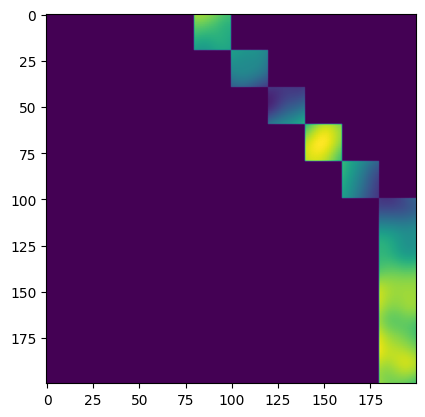

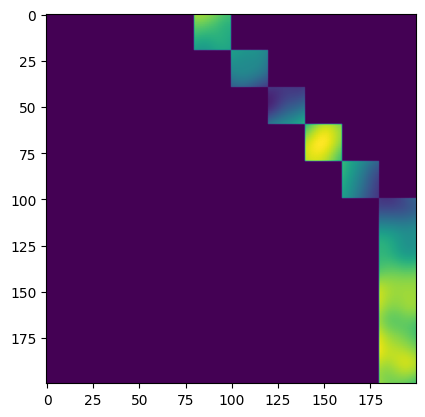

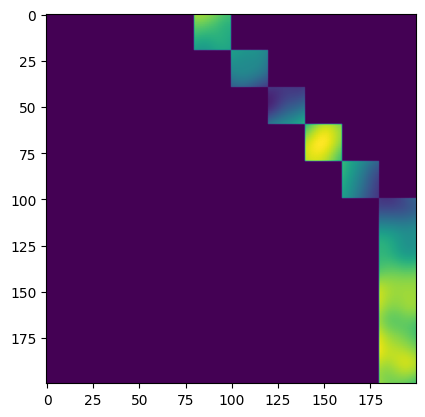

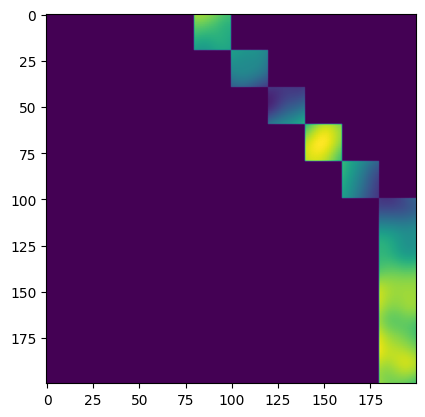

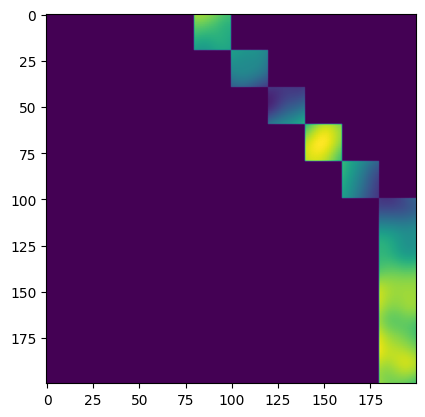

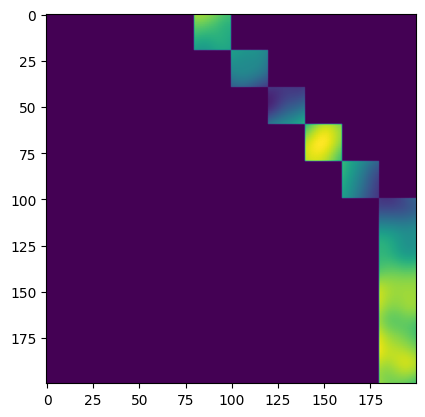

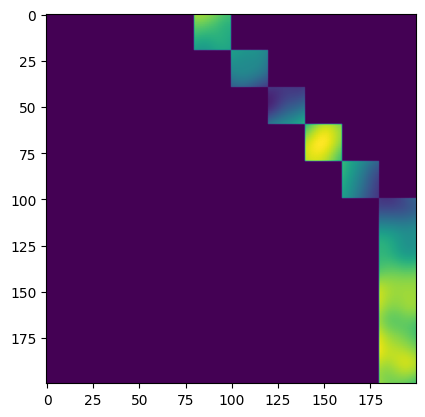

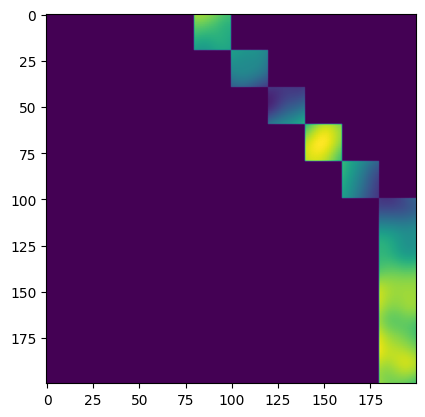

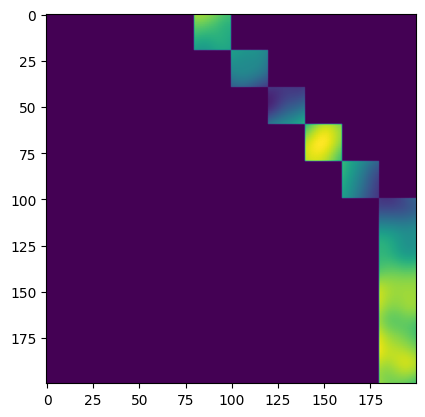

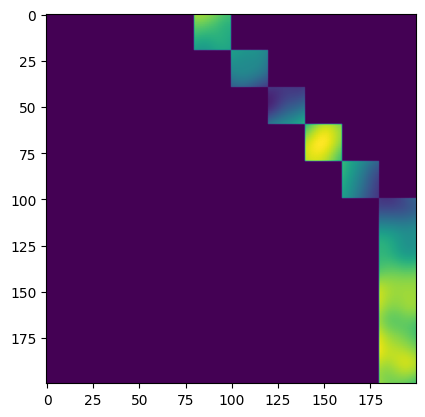

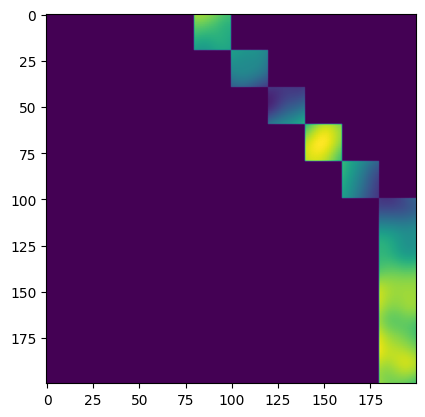

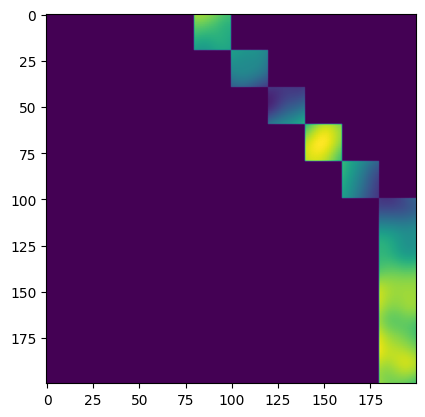

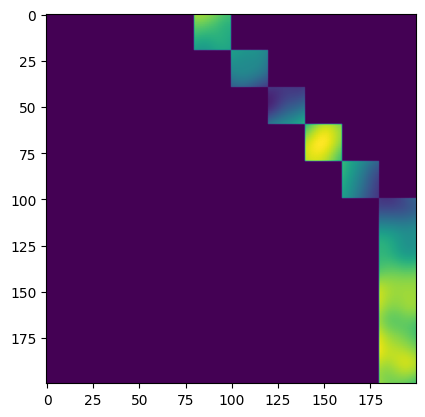

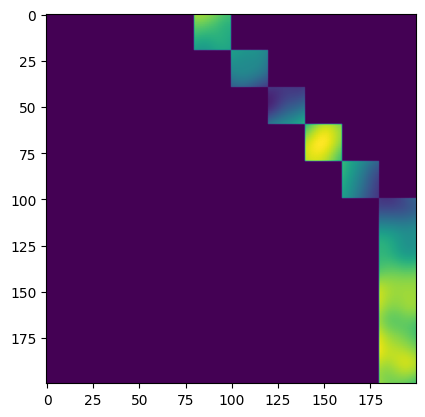

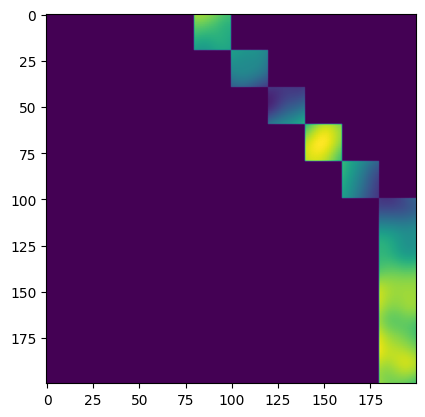

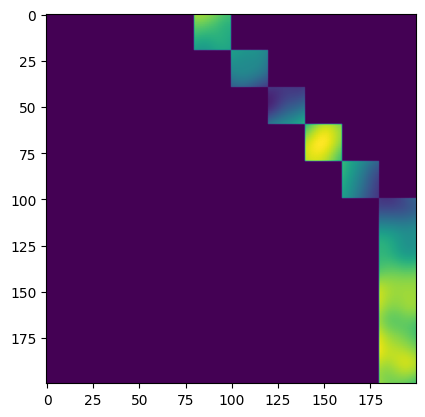

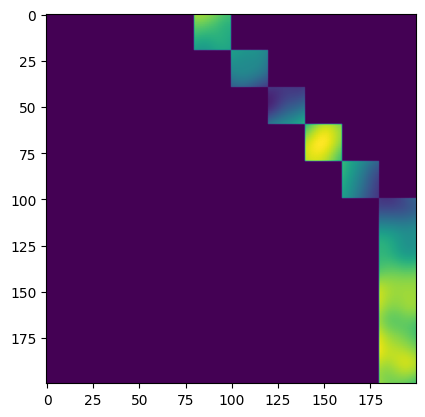

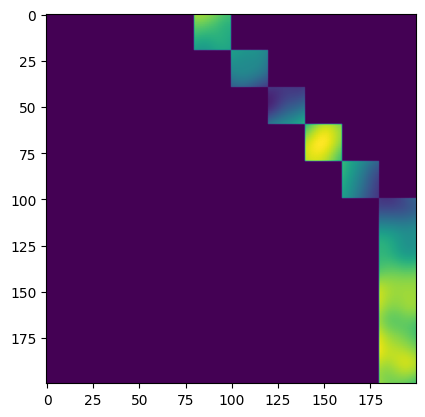

In [61]:
for i in range(len(test_maps)):
    plt.imshow(test_maps[i])
    plt.show()